In [28]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from torch import nn
from sklearn import metrics
from pytorch_tabnet.tab_model  import TabNetClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pytorch_tabnet.metrics import Metric
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, average_precision_score
import warnings
warnings.filterwarnings('ignore')

In [49]:
# 데이터 불러오기
train_data = pd.read_csv("~/project/MIMIC-III/Baseline/overlap/OSI/overlap_OSI(1%)_train.csv")
test_data = pd.read_csv("~/project/MIMIC-III/Baseline/overlap/OSI/overlap_OSI(1%)_test.csv")

# Overlap ARDS
ARDS = pd.read_csv("~/project/MIMIC-III/ARDS.csv")
ARDS.drop("y", axis=1, inplace=True)

train_data = pd.merge(train_data, ARDS, on=['SUBJECT_ID', 'HADM_ID'], how='inner')
test_data = pd.merge(test_data, ARDS, on=['SUBJECT_ID', 'HADM_ID'], how='inner')

train_data.drop(["SUBJECT_ID","HADM_ID", "DOA", "TLOS", "ETHNICITY"], axis=1, inplace=True)
test_data.drop(["SUBJECT_ID","HADM_ID", "DOA", "TLOS", "ETHNICITY"], axis=1, inplace=True)

train_data = pd.get_dummies(train_data, columns=["GENDER"])
test_data = pd.get_dummies(test_data, columns=["GENDER"])

# train_data와 test_data의 칼럼을 맞추기 위해 차집합을 계산
missing_columns_in_test = set(train_data.columns) - set(test_data.columns)
missing_columns_in_train = set(test_data.columns) - set(train_data.columns)

# test_data에 train_data의 더미 변수를 추가하고 0으로 채워주기
for col in missing_columns_in_test:
    test_data[col] = 0

# train_data에 test_data의 더미 변수를 추가하고 0으로 채워주기
for col in missing_columns_in_train:
    train_data[col] = 0
    

####################################################################
# Down Sampling
# train 데이터의 레이블 비율 확인
train_labels = train_data['y']
label_counts = train_labels.value_counts()

# train 데이터의 레이블 비율이 1:1이 되도록 분할
class_0_data = train_data[train_data['y'] == 0]
class_1_data = train_data[train_data['y'] == 1]

# 레이블이 0인 데이터 중에서 샘플 개수가 적은 만큼만 선택
num_samples = min(label_counts[0], label_counts[1])
class_0_data = class_0_data.sample(num_samples, random_state=42)

# 레이블이 1인 데이터 중에서 샘플 개수가 적은 만큼만 선택
class_1_data = class_1_data.sample(num_samples, random_state=42)

# 선택한 데이터를 결합하여 최종 train 데이터 생성
train_data = pd.concat([class_0_data, class_1_data])
####################################################################


# train_data split
train_data, valid_data, _, _ = train_test_split(train_data, train_data['y'], test_size=0.2, random_state=42)


# 데이터 분할 결과 확인
print("Train Data:")
print(train_data['y'].value_counts())
print("Validation Data:")
print(valid_data['y'].value_counts())
print("Test Data:")
print(test_data['y'].value_counts())

X_train = train_data.drop('y', axis=1)
y_train = train_data['y']

X_valid = valid_data.drop('y', axis=1)
y_valid = valid_data['y']

X_test = test_data.drop('y', axis=1)
y_test = test_data['y']

clf = TabNetClassifier(cat_emb_dim=3,
                       optimizer_fn=torch.optim.AdamW, # Any optimizer works here
                       mask_type='entmax', # "sparsemax",
                      )

# NaN 값 대체
imputer = SimpleImputer(strategy='mean')
X_train_array = imputer.fit_transform(X_train)
X_valid_array = imputer.transform(X_valid)
X_test_array = imputer.transform(X_test)

# 데이터 스케일링
scaler = StandardScaler()
X_train_array = scaler.fit_transform(X_train_array)
X_valid_array = scaler.transform(X_valid_array)
X_test_array = scaler.transform(X_test_array)

# NaN 값 대체
y_imputer = SimpleImputer(strategy='mean')
y_train_array = y_imputer.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_valid_array = y_imputer.transform(y_valid.values.reshape(-1, 1)).ravel()
y_test_array = y_imputer.transform(y_test.values.reshape(-1, 1)).ravel()

Train Data:
0    923
1    915
Name: y, dtype: int64
Validation Data:
1    234
0    226
Name: y, dtype: int64
Test Data:
0    1037
1     384
Name: y, dtype: int64


In [50]:
# 모델 훈련
clf.fit(
    X_train=X_train_array, y_train=y_train_array,
    eval_set=[(X_train_array, y_train_array), (X_valid_array, y_valid_array)],
    eval_name=['train', 'valid'],
    eval_metric=['accuracy'],
    max_epochs=100, patience=20,
    batch_size=1024,
    virtual_batch_size=256,
    num_workers=1,
    drop_last=False,
)

epoch 0  | loss: 0.81926 | train_accuracy: 0.49347 | valid_accuracy: 0.50217 |  0:00:00s
epoch 1  | loss: 0.76241 | train_accuracy: 0.51632 | valid_accuracy: 0.51304 |  0:00:01s
epoch 2  | loss: 0.73186 | train_accuracy: 0.53972 | valid_accuracy: 0.52826 |  0:00:02s
epoch 3  | loss: 0.70771 | train_accuracy: 0.54951 | valid_accuracy: 0.54348 |  0:00:02s
epoch 4  | loss: 0.71844 | train_accuracy: 0.56638 | valid_accuracy: 0.56304 |  0:00:03s
epoch 5  | loss: 0.69149 | train_accuracy: 0.55495 | valid_accuracy: 0.53043 |  0:00:03s
epoch 6  | loss: 0.69606 | train_accuracy: 0.55332 | valid_accuracy: 0.5087  |  0:00:04s
epoch 7  | loss: 0.70152 | train_accuracy: 0.57399 | valid_accuracy: 0.55    |  0:00:05s
epoch 8  | loss: 0.69118 | train_accuracy: 0.61262 | valid_accuracy: 0.60435 |  0:00:05s
epoch 9  | loss: 0.68422 | train_accuracy: 0.63112 | valid_accuracy: 0.63043 |  0:00:06s
epoch 10 | loss: 0.67225 | train_accuracy: 0.63493 | valid_accuracy: 0.63478 |  0:00:07s
epoch 11 | loss: 0.66

In [51]:
# # 모델 예측
# y_pred_test = clf.predict(X_test_array)

# # 평가 메트릭 계산
# accuracy = metrics.accuracy_score(y_test, y_pred_test)
# print("accuracy:", accuracy)

# precision = metrics.precision_score(y_test, y_pred_test)
# print("precision:", precision)

# recall = metrics.recall_score(y_test, y_pred_test)
# print("recall:", recall)

# f1 = metrics.f1_score(y_test, y_pred_test)
# print("f1 score:", f1)

# print("")

# # 혼동 행렬 출력
# conf_matrix_test = confusion_matrix(y_test, y_pred_test)
# print("Confusion Matrix (Test Data):")
# print(conf_matrix_test)

# # Feature selection
# importance_scores = clf.feature_importances_
# feature_names = X_train.columns

# # X_train 데이터프레임의 열 수와 일치하지 않을 경우, 필요한 처리를 수행하여 일치시킴
# if len(feature_names) > len(importance_scores):
#     # X_train 데이터프레임의 열을 제거하거나 importance_scores에 0을 추가하여 길이를 맞춤
#     importance_scores = np.concatenate([importance_scores, np.zeros(len(feature_names) - len(importance_scores))])
# elif len(feature_names) < len(importance_scores):
#     # importance_scores의 길이를 X_train 데이터프레임의 열 수에 맞게 잘라냄
#     importance_scores = importance_scores[:len(feature_names)]

# # 업데이트된 importance_scores로 데이터프레임 생성
# feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance_scores})

# # 나머지 코드는 이전과 동일
# sorted_feature_importance = feature_importance_df.sort_values('Importance', ascending=False)
# top_10_features = sorted_feature_importance.head(10)

# plt.figure(figsize=(3, 2))
# plt.barh(top_10_features['Feature'], top_10_features['Importance'])
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.title('Top 10 Features of TabNet')
# plt.gca().invert_yaxis()
# plt.show()

Test Accuracy: 61.79
Precision: 38.36
Recall: 68.23
F1-score: 49.11

Confusion Matrix (Test Data):
[[616 421]
 [122 262]]


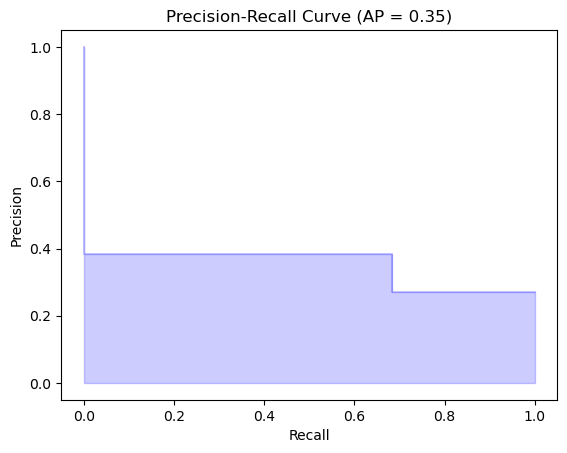

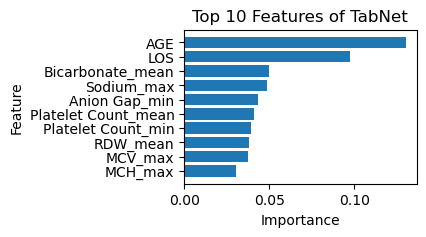

In [52]:
# 모델 예측
y_pred_test = clf.predict(X_test_array)

# 평가 메트릭 계산
accuracy = metrics.accuracy_score(y_test, y_pred_test)
precision = metrics.precision_score(y_test, y_pred_test)
recall = metrics.recall_score(y_test, y_pred_test)
f1 = metrics.f1_score(y_test, y_pred_test)

rounded_accuracy = round(accuracy * 100, 2)
rounded_precision = round(precision * 100, 2)
rounded_recall = round(recall * 100, 2)
rounded_f1 = round(f1 * 100, 2)

print("Test Accuracy:", rounded_accuracy)
print("Precision:", rounded_precision)
print("Recall:", rounded_recall)
print("F1-score:", rounded_f1)

print("")

# 혼동 행렬 출력
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix (Test Data):")
print(conf_matrix_test)

# Precision-Recall Curve 계산
precision, recall, _ = precision_recall_curve(y_test, y_pred_test)
average_precision = average_precision_score(y_test, y_pred_test)

# Precision-Recall Curve 시각화
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.show()

# Feature selection
importance_scores = clf.feature_importances_
feature_names = X_train.columns

# X_train 데이터프레임의 열 수와 일치하지 않을 경우, 필요한 처리를 수행하여 일치시킴
if len(feature_names) > len(importance_scores):
    # X_train 데이터프레임의 열을 제거하거나 importance_scores에 0을 추가하여 길이를 맞춤
    importance_scores = np.concatenate([importance_scores, np.zeros(len(feature_names) - len(importance_scores))])
elif len(feature_names) < len(importance_scores):
    # importance_scores의 길이를 X_train 데이터프레임의 열 수에 맞게 잘라냄
    importance_scores = importance_scores[:len(feature_names)]

# 업데이트된 importance_scores로 데이터프레임 생성
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance_scores})

# 나머지 코드는 이전과 동일
sorted_feature_importance = feature_importance_df.sort_values('Importance', ascending=False)
top_10_features = sorted_feature_importance.head(10)

plt.figure(figsize=(3, 2))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features of TabNet')
plt.gca().invert_yaxis()
plt.show()
